In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model, Sequential, load_model

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras_radam import RAdam

warnings.filterwarnings('ignore')
%matplotlib inline

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


# Dot Product with RMSE loss function

In [2]:
from helpers import load_data

DATA_TRAIN_PATH = "data/data_train.csv"
ratings = load_data(DATA_TRAIN_PATH)

DATA_TEST_PATH = "data/sampleSubmission.csv"
samples = load_data(DATA_TEST_PATH)

In [3]:
samples.head()

,user_id,movie_id,rating
0,37,1,3
1,73,1,3
2,156,1,3
3,160,1,3
4,248,1,3


In [4]:
n_users = len(ratings.user_id.unique())
n_movies = len(ratings.movie_id.unique())

In [5]:
# normalization

# pop_ratings = ratinprefs = pop_ratings['rating']gs[ratings['movie_id'].isin((rating_counts).index[0:500])]
pop_ratings = ratings.set_index(['movie_id', 'user_id'])

prefs = pop_ratings['rating']

mean_0 = prefs.mean() # global mean
prefs = prefs - mean_0

mean_i = prefs.groupby("movie_id").mean() # item mean
prefs = prefs - mean_i

mean_u = prefs.groupby(['user_id']).mean() # user mean
prefs = prefs - mean_u

prefs = prefs.reset_index()

In [6]:
prefs

,movie_id,user_id,rating
0,1,44,0.441303
1,1,61,-0.828520
2,1,67,1.005327
3,1,72,-0.446089
4,1,86,1.303265
...,...,...,...
1176947,1000,9990,0.292686
1176948,1000,9992,1.274889
1176949,1000,9994,-0.741606
1176950,1000,9997,0.664086


In [16]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size=0.2, random_state=1)

In [6]:
test.head()

,user_id,movie_id,rating
1014743,1219,803,5
791571,1865,643,1
967641,1382,771,3
65567,3295,53,3
622228,9259,530,4


In [7]:
from keras import losses
from keras.utils import to_categorical
from keras import backend
from keras.regularizers import l2

K = 25; 

#creating movie embedding path
movie_input = Input(shape=[1], name="Movie-Input")
movie_embedding = Embedding(n_movies+1, K, name="Movie-Embedding", embeddings_regularizer=l2(1e-6))(movie_input)
movie_vec = Flatten(name="Flatten-Movies")(movie_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, K, name="User-Embedding", embeddings_regularizer=l2(1e-6))(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# performing dot product and creating model
prod = Dot(name="Dot-Product", axes=1)([movie_vec, user_vec])
model = Model([user_input, movie_input], prod)
model.compile(loss='mean_squared_error', optimizer='adamax', metrics=['mse', 'accuracy'])

# Optimizer : 'adam', RAdam(), 'sgd'
# Loss = 'categorical_crossentropy', 'mean_squared_error'


Epoch 1/20
941561/941561 [==============================] - 9s 9us/step - loss: 15.4506 - mse: 15.4500 - accuracy: 3.2924e-04
Epoch 2/20
941561/941561 [==============================] - 8s 9us/step - loss: 7.1776 - mse: 7.1703 - accuracy: 0.0758
Epoch 3/20
941561/941561 [==============================] - 8s 9us/step - loss: 1.9177 - mse: 1.9013 - accuracy: 0.2840
Epoch 4/20
941561/941561 [==============================] - 8s 9us/step - loss: 1.2409 - mse: 1.2212 - accuracy: 0.3504
Epoch 5/20
941561/941561 [==============================] - 8s 9us/step - loss: 1.0924 - mse: 1.0712 - accuracy: 0.3605
Epoch 6/20
941561/941561 [==============================] - 8s 9us/step - loss: 1.0482 - mse: 1.0263 - accuracy: 0.3619
Epoch 7/20
941561/941561 [==============================] - 8s 9us/step - loss: 1.0318 - mse: 1.0095 - accuracy: 0.3628
Epoch 8/20
941561/941561 [==============================] - 9s 10us/step - loss: 1.0245 - mse: 1.0020 - accuracy: 0.3630
Epoch 9/20
941561/941561 [======

Text(0, 0.5, 'Training Error')

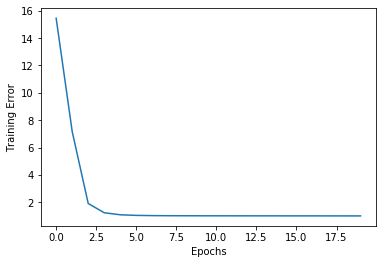

In [8]:
history = model.fit([train.user_id, train.movie_id], train.rating, batch_size=1000, epochs=20, verbose=1)
model.save('MFrmse_model.h5')
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [9]:
model.evaluate([test.user_id, test.movie_id], test.rating)

235391/235391 [==============================] - 7s 30us/step


[1.0262613541788494, 1.0033808946609497, 0.36028140783309937]

In [11]:
prediction_test = model.predict([test.user_id, test.movie_id])

In [12]:
for i in range(prediction_test.shape[0]):
#     pred[i] = np.round(pred[i])
    if (prediction_test[i] < 1):
        prediction_test[i] = 1
    elif (prediction_test[i] > 5):
        prediction_test[i] = 5

In [17]:
test['mf_rmse_rating'] = prediction_test
test

,user_id,movie_id,rating,mf_rmse_rating
1014743,1219,803,5,3.738365
791571,1865,643,1,4.326094
967641,1382,771,3,3.015132
65567,3295,53,3,3.683027
622228,9259,530,4,4.137760
...,...,...,...,...
468443,2110,403,5,3.889833
1064490,9211,855,2,3.143407
1172922,7228,996,3,3.431674
327551,9827,272,5,3.784743


In [26]:
DATA_BLENDING_TEST = "data/mf_rmse_test.csv"
test.to_csv(DATA_BLENDING_TEST)

In [19]:
pred_samples = model.predict([samples.user_id, samples.movie_id])

In [19]:
# pop_samples = samples.set_index(['movie_id', 'user_id'])

# pred_samples = pop_samples['rating']

# pred_samples = pred_samples + mean_u
# pred_samples = pred_samples + mean_i
# pred_samples = pred_samples + mean_0

# prediction = pred_samples.reset_index()

# pred_samples = (prediction['rating']).to_numpy()

In [20]:
np.asarray(pred_samples)

array([[3.3585348],
       [3.063907 ],
       [3.7269037],
       ...,
       [3.1934314],
       [3.1490066],
       [3.8730383]], dtype=float32)

In [21]:
for i in range(pred_samples.shape[0]):
#     pred[i] = np.round(pred[i])
    if (pred_samples[i] < 1):
        pred_samples[i] = 1
    elif (pred_samples[i] > 5):
        pred_samples[i] = 5

In [23]:
submission = load_data(DATA_TEST_PATH)
submission['mf_rmse_rating'] = pred_samples
submission

,user_id,movie_id,rating,mf_rmse_rating
0,37,1,3,3.358535
1,73,1,3,3.063907
2,156,1,3,3.726904
3,160,1,3,3.348716
4,248,1,3,3.328342
...,...,...,...,...
1176947,9974,1000,3,3.712515
1176948,9977,1000,3,3.615162
1176949,9978,1000,3,3.193431
1176950,9982,1000,3,3.149007


In [25]:
DATA_BLENDING_SUBMISSION = "data/mf_rmse_submission.csv"
test.to_csv(DATA_BLENDING_SUBMISSION)

In [40]:
from helpers import create_csv

DATA_SUBMISSION = "data/samples_MF_RMSEnorm.csv"
create_csv(DATA_SUBMISSION, submission)

Dot Product with RMSE using librairies : pandas and keras - AICrowd : RMSE = .... ; Secondary = ....

In [ ]:
## Problems : the prediction has 6. ... 